In [39]:
import csv
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
# User Defined Functions
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
# Stats
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from math import sqrt

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [40]:
# Creates a new Spark session w/in Python
spark = SparkSession.builder.appName("Final Project").getOrCreate()

# The Data

The dataset our group chose was based on hourly energy demand for 5 cities in Spain (https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather). The goal of this Jupyter Notebook is to explore the data to look for important relationships in the data

This will be done using PySpark as we have learned in class and matplotlib for visualiztion

# Data Setup
Importing the data

In [41]:
# Reads the local csv stored on my computer, it does have a header
energy_df = spark.read.csv("C:\\Users\\Wes\\Desktop\\CS 490\\energy_dataset.csv", header = True, inferSchema=True)
weather_df = spark.read.csv("C:\\Users\\Wes\\Desktop\\CS 490\\weather_features.csv", header = True, inferSchema=True)
# Creates a temporary view from the dataframe we read from the file
# This is how we can read SQL from it
energy_df.createOrReplaceTempView("Energy")
weather_df.createOrReplaceTempView("Weather")

Creating the Combined dataframe

In [42]:
joined_df = energy_df.join(weather_df, energy_df.time == weather_df.dt_iso)
joined_df.show(1, vertical=True)

-RECORD 0----------------------------------------------------------
 time                                        | 2015-01-01 00:00:00 
 generation_biomass                          | 447.0               
 generation_fossil_brown_coal_lignite        | 329.0               
 generation_fossil_coal_derived_gas          | 0.0                 
 generation_fossil_gas                       | 4844.0              
 generation_fossil_hard_coal                 | 4821.0              
 generation_fossil_oil                       | 162.0               
 generation_fossil_oil_shale                 | 0.0                 
 generation_fossil_peat                      | 0.0                 
 generation_geothermal                       | 0.0                 
 generation_hydro_pumped_storage_aggregated  | null                
 generation_hydro_pumped_storage_consumption | 863.0               
 generation_hydro_run_of_river_and_poundage  | 1051.0              
 generation_hydro_water_reservoir            | 1

Creating columns for Farenheight temperatures and filling na values

In [43]:
# Convert Kelvin temps to Farhenheight
k_to_f_udf = udf(lambda kelvin: (float(kelvin) - 273.15) * (9/5) + 32, DoubleType())
joined_df = joined_df.withColumn("temp_f", k_to_f_udf(joined_df.temp))
joined_df = joined_df.withColumn("temp_min_f", k_to_f_udf(joined_df.temp_min))
joined_df = joined_df.withColumn("temp_max_f", k_to_f_udf(joined_df.temp_max))
joined_df.na.fill(0)

DataFrame[time: string, generation_biomass: double, generation_fossil_brown_coal_lignite: double, generation_fossil_coal_derived_gas: double, generation_fossil_gas: double, generation_fossil_hard_coal: double, generation_fossil_oil: double, generation_fossil_oil_shale: double, generation_fossil_peat: double, generation_geothermal: double, generation_hydro_pumped_storage_aggregated: string, generation_hydro_pumped_storage_consumption: double, generation_hydro_run_of_river_and_poundage: double, generation_hydro_water_reservoir: double, generation_marine: double, generation_nuclear: double, generation_other: double, generation_other_renewable: double, generation_solar: double, generation_waste: double, generation_wind_offshore: double, generation_wind_onshore: double, forecast_solar_day_ahead: double, forecast_wind_offshore_eday_ahead: string, forecast_wind_onshore_day_ahead: double, total_load_forecast: double, total_load_actual: double, price_day_ahead: double, price_actual: double, dt_

# Data Exploration

## By City

Based on the 5 cities within the dataset I wanted to see how the data varied between them

In [44]:
test_agg = joined_df.groupBy("city_name", "weather_main")\
    .agg({"time" : "count", "price_actual" : "avg"})\
    .withColumnRenamed('count(time)', 'count')\
    .withColumnRenamed('avg(price_actual)', 'avg_price')\
    .filter("count > 100")\
    .orderBy("city_name", "weather_main")
test_agg.show(100, False)

+----------+------------+------------------+-----+
|city_name |weather_main|avg_price         |count|
+----------+------------+------------------+-----+
| Barcelona|clear       |59.30181183960987 |14764|
| Barcelona|clouds      |57.059017502482575|16112|
| Barcelona|drizzle     |56.17348837209302 |301  |
| Barcelona|mist        |55.9887133182844  |443  |
| Barcelona|rain        |55.62026551226556 |3465 |
| Barcelona|thunderstorm|62.42364820846908 |307  |
|Bilbao    |clear       |60.56761825922418 |8456 |
|Bilbao    |clouds      |57.37178233815964 |16714|
|Bilbao    |drizzle     |60.67769072164944 |485  |
|Bilbao    |fog         |62.91078397212544 |1148 |
|Bilbao    |mist        |59.97895819508959 |1507 |
|Bilbao    |rain        |54.971499514495804|7209 |
|Bilbao    |snow        |55.17807228915661 |166  |
|Bilbao    |thunderstorm|58.42384615384614 |208  |
|Madrid    |clear       |58.671028877320325|20362|
|Madrid    |clouds      |56.2445749178017  |10645|
|Madrid    |drizzle     |57.666

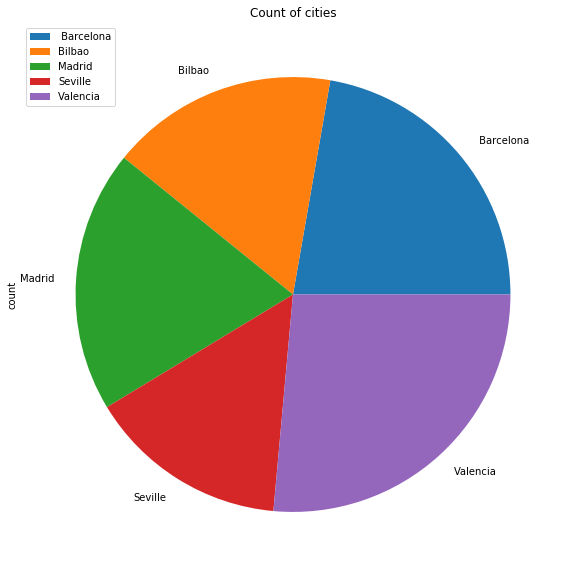

In [45]:
graph_df = test_agg.select('*').toPandas()
plt.rcParams["figure.figsize"] = 18,10
graph_df.groupby(['city_name']).mean().plot(kind='pie',y='count', title='Count of cities')

The representation of data between the cities within the dataset is very similar, with Valencia being the most represented and Seville being the least represented

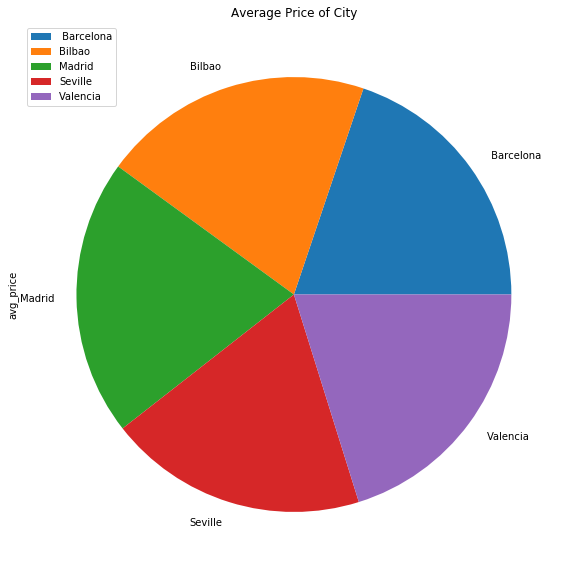

In [46]:
graph_df.groupby(['city_name']).mean().plot(kind='pie',y='avg_price', title='Average Price of City')

The average price between each city is nearly identical as well. This is something we had hoped to see, as it means the pricing is fair between each city and no one customer is paying more than another just for living in a different city 

# Correlation

In [47]:
def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.setHandleInvalid("keep").transform(df).select(vector_col)
    np.nan_to_num(df_vector)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)

The above function takes in a (Pyspark-style) dataframe and a list of columns to create a Correlation matrix of the values

## By Wind Speed

Does the price depend on the wind speed?

In [48]:
test_agg = joined_df.groupBy("wind_speed")\
    .agg({"time" : "count", "price_actual" : "avg"})\
    .withColumnRenamed('count(time)', 'count')\
    .withColumnRenamed('avg(price_actual)', 'avg_price')\
    .filter("count > 100")\
    .sort("wind_speed")
test_agg.show(100, False)

+----------+------------------+-----+
|wind_speed|avg_price         |count|
+----------+------------------+-----+
|0         |58.48113213667815 |18496|
|1         |59.43090143599589 |55223|
|2         |59.01943278830858 |34555|
|3         |58.0480008785592  |25041|
|4         |57.06761207885105 |18313|
|5         |55.98622442865706 |11683|
|6         |54.275993523697394|6794 |
|7         |51.87357766604919 |3779 |
|8         |48.61905970850964 |2127 |
|9         |46.72045927209707 |1154 |
|10        |43.998986866791746|533  |
|11        |45.793608562691134|327  |
|12        |48.36364532019704 |203  |
+----------+------------------+-----+



In [49]:
correlation_matrix(test_agg, test_agg.columns)

,wind_speed,avg_price,count
wind_speed,1.000000,-0.934583,-0.814867
avg_price,-0.934583,1.000000,0.807062
count,-0.814867,0.807062,1.000000


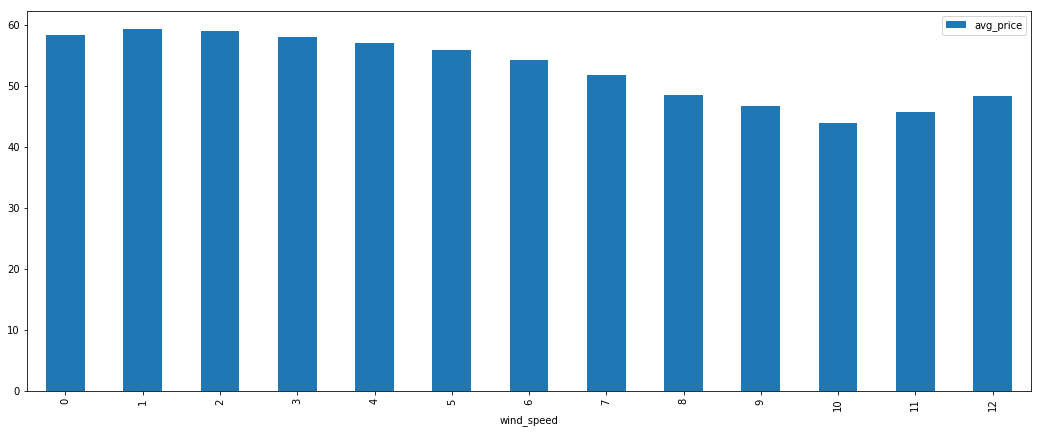

In [50]:
graph_df = test_agg.select('*').toPandas()
plt.rcParams["figure.figsize"] = 18,7
graph_df.plot.bar(x='wind_speed',
                  y='avg_price')

There seems to be a strong negative correlation between wind speed and average price, although as the wind speeds get higher, there is less and less of a count of these represented in the data, so higher values aren't as trustworthy as the lower ones.

## By Month and Day

In [51]:
test_agg = joined_df.groupBy(f.month('time'), f.dayofmonth('time'))\
    .agg({"time" : "count", "price_actual" : "avg"})\
    .withColumnRenamed('dayofmonth(time)', 'day_of_month')\
    .withColumnRenamed('month(time)', 'month')\
    .withColumnRenamed('count(time)', 'count')\
    .withColumnRenamed('avg(price_actual)', 'avg_price')\
    .orderBy('month', 'day_of_month')\
    .filter("count > 100")
test_agg.show(10,False)

+-----+------------+------------------+-----+
|month|day_of_month|avg_price         |count|
+-----+------------+------------------+-----+
|1    |1           |46.19534161490682 |483  |
|1    |2           |56.790477178423245|482  |
|1    |3           |54.05941414141414 |495  |
|1    |4           |55.018605577689236|502  |
|1    |5           |60.3349007936508  |504  |
|1    |6           |55.52820512820514 |507  |
|1    |7           |59.728073217726376|519  |
|1    |8           |65.08919087136927 |482  |
|1    |9           |64.61051792828685 |502  |
|1    |10          |56.60917647058824 |510  |
+-----+------------+------------------+-----+
only showing top 10 rows



In [52]:
correlation_matrix(test_agg, test_agg.columns)

,month,day_of_month,avg_price,count
month,1.000000,0.006443,0.595330,0.081220
day_of_month,0.006443,1.000000,0.045038,-0.073601
avg_price,0.595330,0.045038,1.000000,0.259623
count,0.081220,-0.073601,0.259623,1.000000


According to the correlations, the average price seems to depend much more on what month it is than the day of the month. This tracks as we expect energy costs to vary throughout the year as temperatures change, as opposed to costs varying wildly over the course of a month

## Temperature, price, and actual load by year and month

Ignoring the day of the month and looking at how temmperature, prices and actual load depend by year and month

In [53]:
test_agg = joined_df.groupBy(f.year('time'), f.month('time'))\
    .agg({"price_actual" : "avg", \
          "total_load_actual" : "avg",\
          "temp_f": "avg",\
          "temp_min_f": "avg",\
          "temp_max_f": "avg"})\
    .withColumnRenamed('year(time)', 'year')\
    .withColumnRenamed('month(time)', 'month')\
    .withColumnRenamed('avg(price_actual)', 'avg_price')\
    .withColumnRenamed('avg(total_load_actual)', 'avg_total_load_actual')\
    .orderBy('year','month')

In [54]:
correlation_matrix(test_agg, test_agg.columns)

,year,month,avg(temp_f),avg(temp_max_f),avg(temp_min_f),avg_total_load_actual,avg_price
year,1.000000,0.000000,-0.024369,-0.061868,0.012814,0.304222,0.201002
month,0.000000,1.000000,0.276436,0.286410,0.260331,-0.210858,0.389448
avg(temp_f),-0.024369,0.276436,1.000000,0.989586,0.989929,-0.104184,0.023399
avg(temp_max_f),-0.061868,0.286410,0.989586,1.000000,0.959802,-0.124596,-0.008685
avg(temp_min_f),0.012814,0.260331,0.989929,0.959802,1.000000,-0.084801,0.047780
avg_total_load_actual,0.304222,-0.210858,-0.104184,-0.124596,-0.084801,1.000000,0.283745
avg_price,0.201002,0.389448,0.023399,-0.008685,0.047780,0.283745,1.000000


At this level of time granularity there are no strong correlations (not counting temperature relates to itself). Month and Average Price are the two strongest correlation present in this relation

## Generation_ by Year

The energy dataset contains many columns concerning the generation of power (measured in MegaWatts). It's important to look at how these relate to the price and total load. This will also do us an important service of telling us if there are any unimportant columns that we can ignore

In [55]:
test_agg = joined_df.groupBy(f.year('time'))\
    .agg({"price_actual" : "avg", \
          "total_load_actual" : "avg",\
          "generation_biomass" : "avg",\
          "generation_fossil_brown_coal_lignite" : "avg",\
          "generation_fossil_coal_derived_gas" : "avg",\
          "generation_fossil_gas" : "avg",\
          "generation_fossil_hard_coal" : "avg",\
          "generation_fossil_oil" : "avg",\
          "generation_fossil_oil_shale" : "avg",\
          "generation_fossil_peat" : "avg",\
          "generation_geothermal" : "avg",\
          "generation_hydro_pumped_storage_aggregated" : "avg",\
          "generation_hydro_pumped_storage_consumption" : "avg",\
          "generation_hydro_run_of_river_and_poundage" : "avg",\
          "generation_hydro_water_reservoir" : "avg",\
          "generation_marine" : "avg",\
          "generation_nuclear" : "avg",\
          "generation_other" : "avg",\
          "generation_other_renewable" : "avg",\
          "generation_solar" : "avg",\
          "generation_waste" : "avg",\
          "generation_wind_offshore" : "avg",\
          "generation_wind_onshore" : "avg",\
         })\
    .withColumnRenamed('year(time)', 'year')\
    .orderBy('year')

In [56]:
correlation_matrix(test_agg, test_agg.columns)

,year,avg(generation_fossil_gas),avg(generation_fossil_brown_coal_lignite),avg(generation_hydro_pumped_storage_aggregated),avg(generation_fossil_peat),avg(generation_wind_offshore),avg(generation_hydro_water_reservoir),avg(total_load_actual),avg(generation_solar),avg(generation_geothermal),...,avg(generation_hydro_pumped_storage_consumption),avg(generation_biomass),avg(generation_marine),avg(generation_waste),avg(generation_fossil_hard_coal),avg(generation_fossil_coal_derived_gas),avg(generation_hydro_run_of_river_and_poundage),avg(generation_fossil_oil_shale),avg(generation_wind_onshore),avg(generation_fossil_oil)
year,1.000000,0.707407,-0.443560,NaN,NaN,NaN,-0.112402,0.988030,-0.376027,NaN,...,-0.870629,-0.863918,NaN,0.950379,-0.701993,NaN,0.522804,NaN,0.514543,-0.796692
avg(generation_fossil_gas),0.707407,1.000000,0.296033,NaN,NaN,NaN,-0.750713,0.772630,0.386652,NaN,...,-0.819886,-0.678732,NaN,0.855207,-0.241981,NaN,-0.230797,NaN,-0.067438,-0.424401
avg(generation_fossil_brown_coal_lignite),-0.443560,0.296033,1.000000,NaN,NaN,NaN,-0.840437,-0.320710,0.982195,NaN,...,0.040494,0.420684,NaN,-0.240190,0.771253,NaN,-0.948702,NaN,-0.608724,0.661934
avg(generation_hydro_pumped_storage_aggregated),NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg(generation_fossil_peat),NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg(generation_wind_offshore),NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg(generation_hydro_water_reservoir),-0.112402,-0.750713,-0.840437,NaN,NaN,NaN,1.000000,-0.243325,-0.857189,NaN,...,0.488484,0.043260,NaN,-0.302046,-0.442907,NaN,0.728486,NaN,0.345629,-0.264612
avg(total_load_actual),0.988030,0.772630,-0.320710,NaN,NaN,NaN,-0.243325,1.000000,-0.266476,NaN,...,-0.935592,-0.807328,NaN,0.946351,-0.586183,NaN,0.435614,NaN,0.513215,-0.701659
avg(generation_solar),-0.376027,0.386652,0.982195,NaN,NaN,NaN,-0.857189,-0.266476,1.000000,NaN,...,0.030115,0.274732,NaN,-0.131752,0.644033,NaN,-0.976062,NaN,-0.710615,0.525526
avg(generation_geothermal),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The following columns can be ignored:
    - generation_hydro_pumped_storage_aggregated
    - generation_fossil_peat
    - generation_wind_offshore
    - generation_geothermal
    - generation_marine
    - generation_fossil_coal_derived_gas
    - generation_fossil_oil_shale
    
Using the correlations listed above, strong ones will be visualized and analyzed

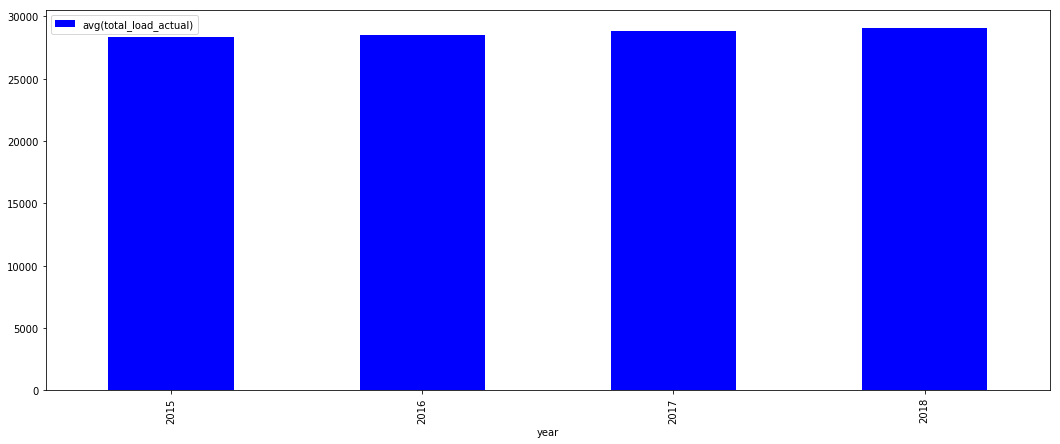

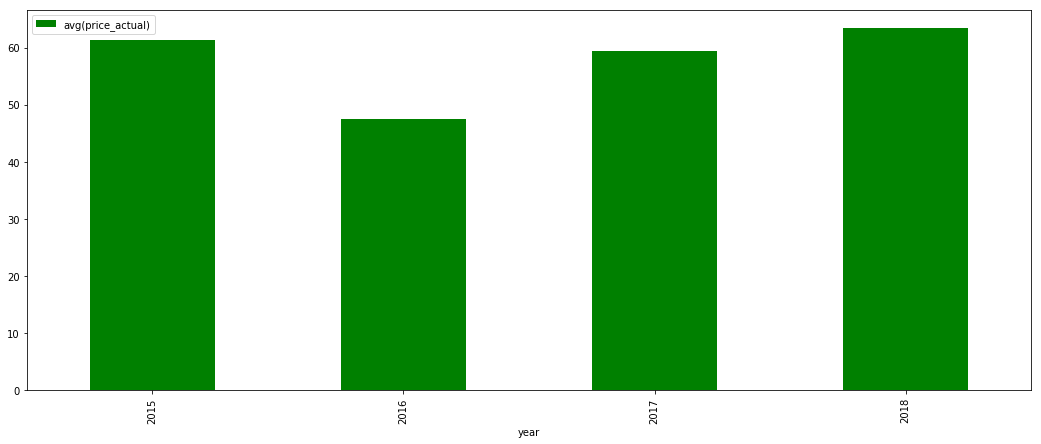

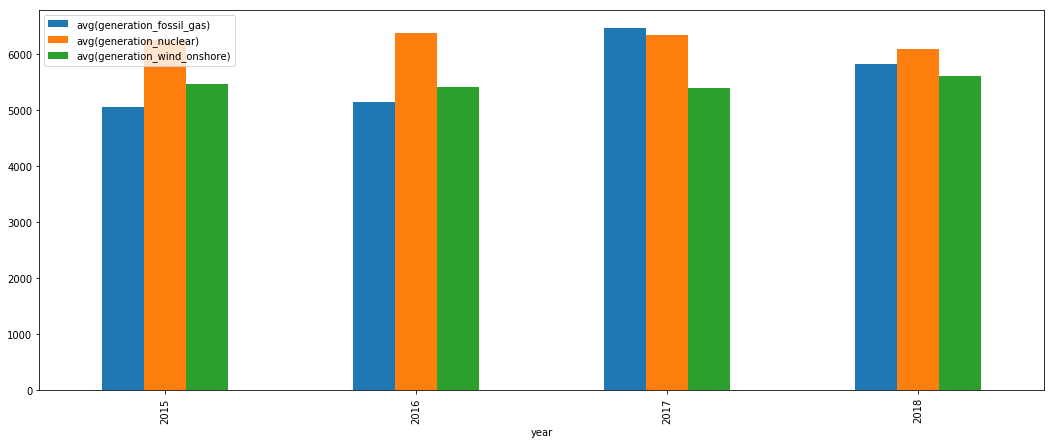

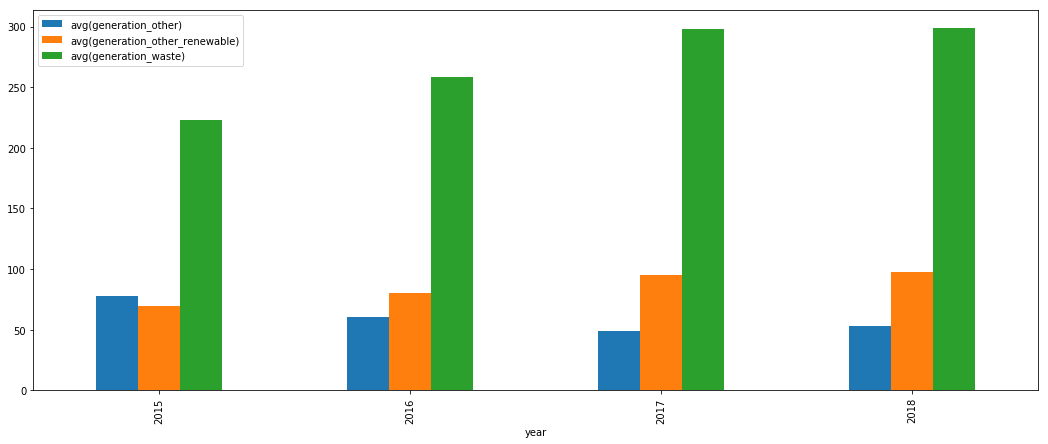

In [62]:
graph_df = test_agg.select('*').toPandas()
plt.rcParams["figure.figsize"] = 18,7
graph_df.plot.bar(x='year', y='avg(total_load_actual)', color='blue')
graph_df.plot.bar(x='year', y='avg(price_actual)', color='green')
graph_df.plot.bar(x='year',
                  y=['avg(generation_fossil_gas)',
                     'avg(generation_nuclear)',
                     'avg(generation_wind_onshore)'],
                  sharex=True)
graph_df.plot.bar(x='year',
                  y=['avg(generation_other)',
                     'avg(generation_other_renewable)',
                     'avg(generation_waste)'],
                  sharex=True)

The total load varies very little by year, meaning that overall the system is undertaking approximately the same amount of work each year. This is important to note beacuse any patterns of increase or decrease we find within a Generation column, means that it is generally cancelled out by the decrease or increase in another Generation column

There was a substantial price difference in 2016, being much lower than the surrounding years.

Looking at a subset of Generation columns we can start to see how they each begin to follow their own pattern, and some of them draw much much more power than others. 

The following generate an incredibly high MegaWatt drain:
    - Generation Fossil Gas
    - Generation Nuclear
    - Generation Wind Onshore
    
The following have a very small draw in comparison:
    - Generation Other
    - Generation Other Renewable
    - Generation Waste

## Generation_ By Month

Looking at the same Generation columns as we did above, but this time at a Month granularity as opposed to year. We are also ignoring any column that was deemed unimportant

In [63]:
test_agg = joined_df.groupBy(f.month('time'))\
    .agg({"price_actual" : "avg", \
          "total_load_actual" : "avg",\
          "generation_biomass" : "avg",\
          "generation_fossil_brown_coal_lignite" : "avg",\
          "generation_fossil_gas" : "avg",\
          "generation_fossil_hard_coal" : "avg",\
          "generation_fossil_oil" : "avg",\
          "generation_hydro_pumped_storage_consumption" : "avg",\
          "generation_hydro_run_of_river_and_poundage" : "avg",\
          "generation_hydro_water_reservoir" : "avg",\
          "generation_nuclear" : "avg",\
          "generation_other" : "avg",\
          "generation_other_renewable" : "avg",\
          "generation_solar" : "avg",\
          "generation_waste" : "avg",\
          "generation_wind_onshore" : "avg",\
         })\
    .withColumnRenamed('month(time)', 'month')\
    .orderBy('month')

In [64]:
correlation_matrix(test_agg, test_agg.columns)

,month,avg(generation_fossil_gas),avg(generation_fossil_brown_coal_lignite),avg(generation_hydro_water_reservoir),avg(total_load_actual),avg(generation_solar),avg(generation_other),avg(price_actual),avg(generation_other_renewable),avg(generation_nuclear),avg(generation_hydro_pumped_storage_consumption),avg(generation_biomass),avg(generation_waste),avg(generation_fossil_hard_coal),avg(generation_hydro_run_of_river_and_poundage),avg(generation_wind_onshore),avg(generation_fossil_oil)
month,1.000000,0.721932,0.627535,-0.801728,-0.250626,-0.152388,0.036723,0.688920,0.502845,-0.250136,-0.496155,-0.007149,0.534335,0.566349,-0.707855,-0.610899,-0.009340
avg(generation_fossil_gas),0.721932,1.000000,0.893011,-0.815705,0.326877,-0.127170,0.204300,0.864872,0.400812,-0.266553,-0.462019,0.408114,0.713947,0.915238,-0.766604,-0.501046,0.339675
avg(generation_fossil_brown_coal_lignite),0.627535,0.893011,1.000000,-0.859472,0.351370,-0.162395,0.223083,0.935969,0.490832,-0.035546,-0.438496,0.545007,0.804039,0.976464,-0.872877,-0.542033,0.429313
avg(generation_hydro_water_reservoir),-0.801728,-0.815705,-0.859472,1.000000,-0.044412,-0.047851,-0.205382,-0.868178,-0.388870,-0.000075,0.650480,-0.430973,-0.850827,-0.835560,0.960015,0.751825,-0.349102
avg(total_load_actual),-0.250626,0.326877,0.351370,-0.044412,1.000000,0.014620,0.388074,0.295006,-0.327580,0.281043,0.061434,0.664148,0.289135,0.464990,-0.062771,0.218531,0.626397
avg(generation_solar),-0.152388,-0.127170,-0.162395,-0.047851,0.014620,1.000000,-0.299850,-0.304441,-0.474513,-0.095104,-0.725989,0.067916,0.155315,-0.128250,0.047322,-0.554381,0.294699
avg(generation_other),0.036723,0.204300,0.223083,-0.205382,0.388074,-0.299850,1.000000,0.344915,-0.048247,0.300006,0.133208,0.702590,0.110818,0.301946,-0.297569,0.314799,0.591783
avg(price_actual),0.688920,0.864872,0.935969,-0.868178,0.295006,-0.304441,0.344915,1.000000,0.568724,0.009509,-0.294214,0.494994,0.748662,0.928118,-0.850738,-0.419002,0.324440
avg(generation_other_renewable),0.502845,0.400812,0.490832,-0.388870,-0.327580,-0.474513,-0.048247,0.568724,1.000000,-0.445214,0.027449,-0.104189,0.094508,0.403654,-0.360714,-0.196771,-0.226934
avg(generation_nuclear),-0.250136,-0.266553,-0.035546,-0.000075,0.281043,-0.095104,0.300006,0.009509,-0.445214,1.000000,0.213965,0.236782,0.303606,-0.058392,-0.150658,0.187460,0.268101


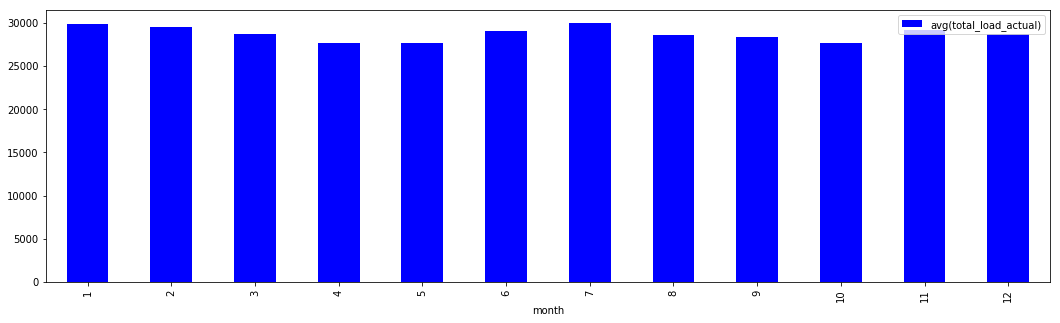

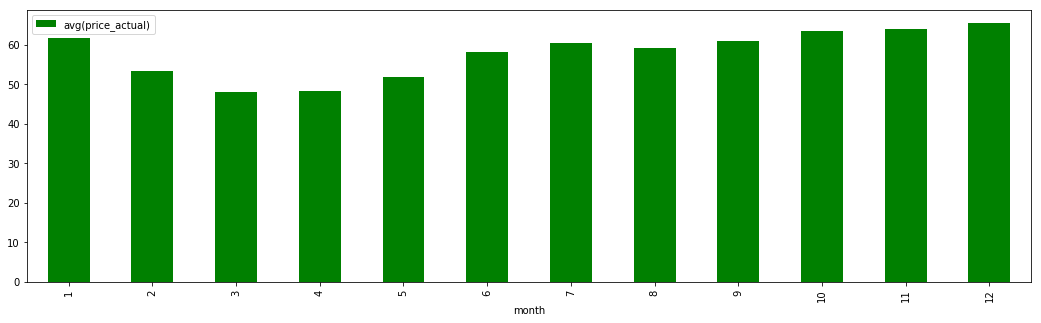

In [66]:
graph_df = test_agg.select('*').toPandas()
plt.rcParams["figure.figsize"] = 18,5
graph_df.plot.bar(x='month', y='avg(total_load_actual)', color='blue')
graph_df.plot.bar(x='month', y='avg(price_actual)', color='green')

Looking by Month we can see a stronger indication of pattern, especially when looking by price. March and April being the cheapest month for the customers; December and January being the most expensive.

The total load remains generally consistent but the price and load do not seem to strongly influence one another.

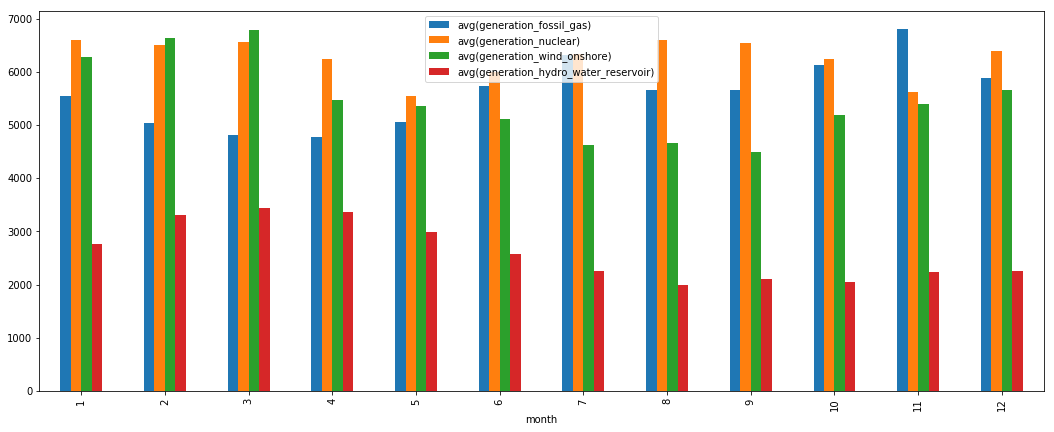

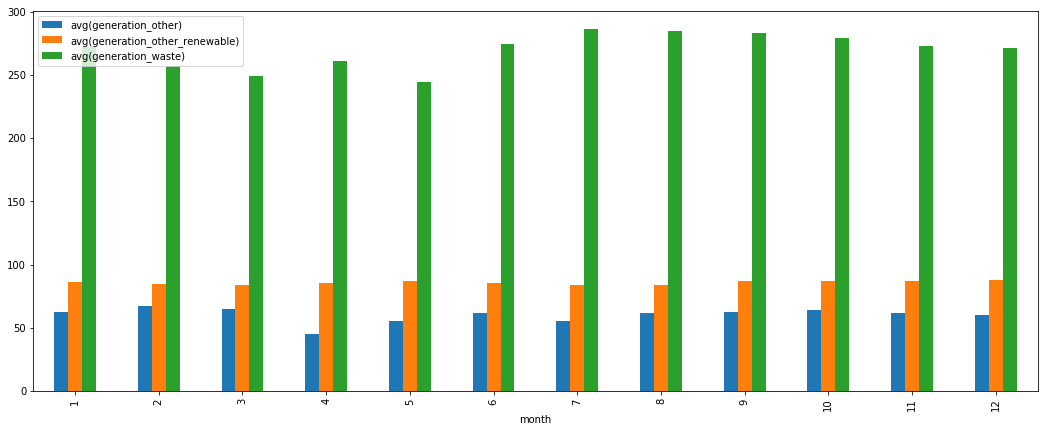

In [68]:
plt.rcParams["figure.figsize"] = 18,7

graph_df.plot.bar(x='month',
                  y=['avg(generation_fossil_gas)',
                     'avg(generation_nuclear)',
                     'avg(generation_wind_onshore)',
                     'avg(generation_hydro_water_reservoir)'],
                  sharex=True)
graph_df.plot.bar(x='month',
                  y=['avg(generation_other)',
                     'avg(generation_other_renewable)',
                     'avg(generation_waste)'],
                  sharex=True)

Increasing our time granularity to Month we can see stronger patterns begin to emerge. It's interesting to note that some Generation columns have a strong correlation to one another as well.

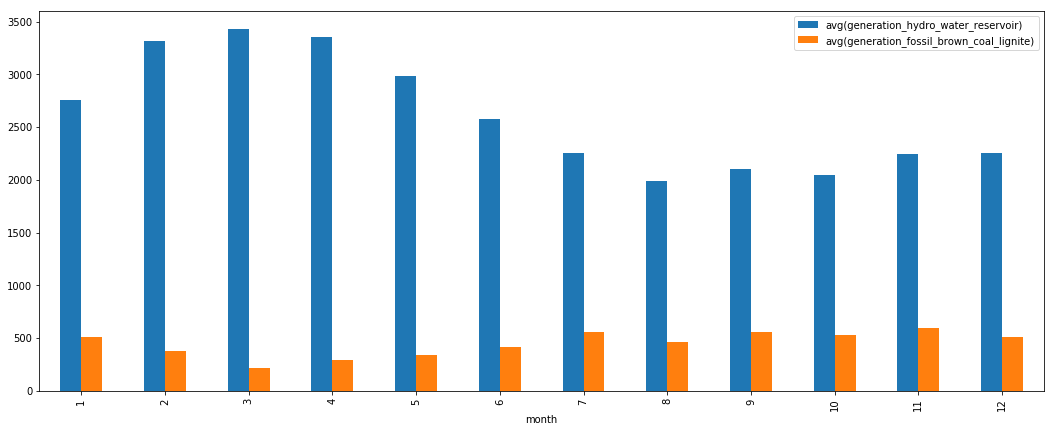

In [70]:
graph_df.plot.bar(x='month',
                  y=['avg(generation_hydro_water_reservoir)',
                     'avg(generation_fossil_brown_coal_lignite)'],
                  sharex=True)

There is a very strong negative correlation between Hydro Water Reservoir and Fossil Brown Coal Lignite. I don't have enough domain knowledge about this subject to know whether or not this is to be expected

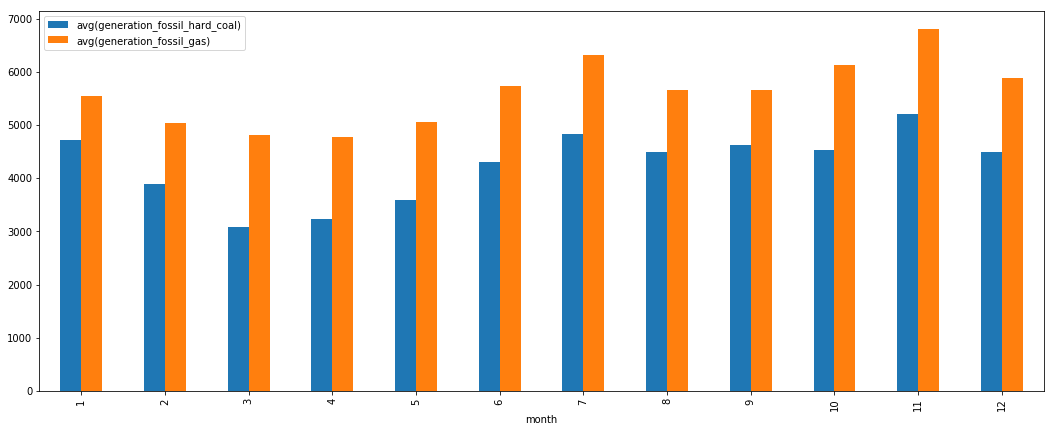

In [71]:
graph_df.plot.bar(x='month',
                  y=['avg(generation_fossil_hard_coal)',
                     'avg(generation_fossil_gas)'],
                  sharex=True)

Others Generation columns have a very strong Generation columns that we can expect, such as two separate Fossil Generation columns

# Does hour of day affect Energy Price or Load?

Going to an even deeper level of time granularity, how does the hour of day affect energy price or load?

In [17]:
test_agg = joined_df.groupBy(f.hour('time'))\
    .agg({"total_load_actual" : "avg", \
          "price_actual" : "avg"})\
    .withColumnRenamed('hour(time)', 'hour')\
    .orderBy('hour(time)')
test_agg.show(10,False)

+----+------------------+----------------------+
|hour|avg(price_actual) |avg(total_load_actual)|
+----+------------------+----------------------+
|0   |55.54451529921473 |26289.17059301381     |
|1   |51.87812483076095 |24592.89371784457     |
|2   |49.380810010764236|23437.54036598493     |
|3   |47.999081124714095|22921.079752121783    |
|4   |47.443314939434686|22708.48923283984     |
|5   |48.44930890475544 |23000.831356160692    |
|6   |52.360210908113935|24573.628559914025    |
|7   |56.37116581701105 |26974.129768941428    |
|8   |60.264768123667416|28852.69021231139     |
|9   |61.81943133616112 |30442.86859954781     |
+----+------------------+----------------------+
only showing top 10 rows



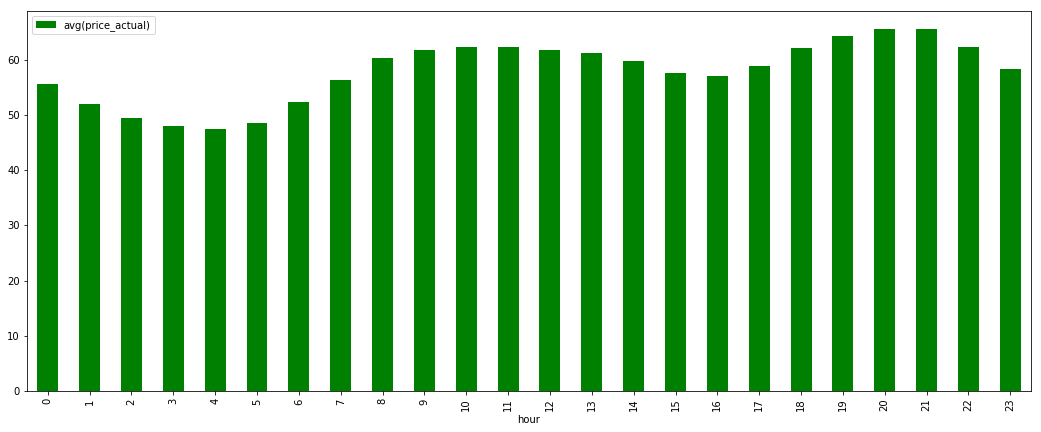

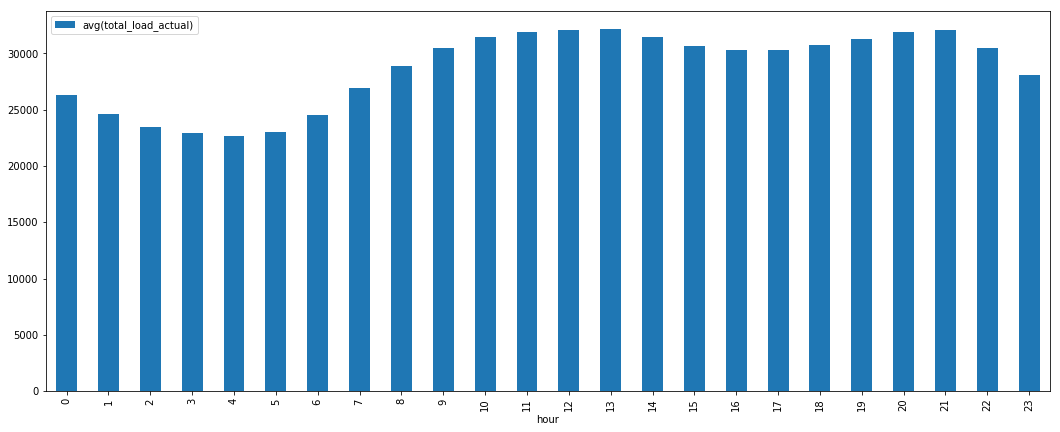

In [41]:
graph_df = test_agg.select('*').toPandas()
plt.rcParams["figure.figsize"] = 18,7
graph_df.plot.bar(x='hour', y='avg(price_actual)', color='green')
graph_df.plot.bar(x='hour', y='avg(total_load_actual)')

In [18]:
correlation_matrix(test_agg, test_agg.columns)

,hour,avg(price_actual),avg(total_load_actual)
hour,1.000000,0.743679,0.741345
avg(price_actual),0.743679,1.000000,0.948137
avg(total_load_actual),0.741345,0.948137,1.000000


Total load on the system and actual price very strongly with the hour of day. Peak hour being the afternoon and late night, and lowest hours being 3-5 am

# Conclusions

Looking through the data we've found a number of strong correlations within the data

We only had a brief introduction into machine learning within our CS 490, but time-series analysis would be a strong contender for this dataset as it would allow us to predict upcoming prices, load usage and energy generation for upcoming years and months